In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense , Dropout , Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.vis_utils import plot_model
import random
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample # Correcting the imbalance discovered by using resample
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import accuracy_score, mean_absolute_error ,mean_squared_error, confusion_matrix, median_absolute_error,classification_report, f1_score,recall_score,precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [4]:
train = pd.read_csv('/content/fraudTrain.csv')
test = pd.read_csv('/content/fraudTest.csv')

In [5]:
train['trans_date_trans_time']=pd.to_datetime(train['trans_date_trans_time'])
train['trans_date']=train['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
train['trans_date']=pd.to_datetime(train['trans_date'])
train['dob']=pd.to_datetime(train['dob'])

test['trans_date_trans_time']=pd.to_datetime(test['trans_date_trans_time'])
test['trans_date']=test['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
test['trans_date']=pd.to_datetime(test['trans_date'])
test['dob']=pd.to_datetime(test['dob'])

In [6]:
train.drop("Unnamed: 0",axis=1,inplace=True)
test.drop("Unnamed: 0",axis=1,inplace=True)

In [7]:
total = pd.concat([test,train])

In [8]:
total["is_fraud_cat"]=total.is_fraud.apply(lambda x: "T" if x==1 else "F")
total["is_fraud_cat"].astype("object")

0          F
1          F
2          F
3          F
4          F
          ..
1296670    F
1296671    F
1296672    F
1296673    F
1296674    F
Name: is_fraud_cat, Length: 1852394, dtype: object

In [9]:
totalcat=total.select_dtypes(include=['object'])
del total['is_fraud_cat']

In [10]:
#finding numerical columns
testnum= test.select_dtypes(include=np.number)
test[testnum.columns]

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
0,2291163933867244,2.86,29209,33.9659,-80.9355,333497,1371816865,33.986391,-81.200714,0
1,3573030041201292,29.84,84002,40.3207,-110.4360,302,1371816873,39.450498,-109.960431,0
2,3598215285024754,41.28,11710,40.6729,-73.5365,34496,1371816893,40.495810,-74.196111,0
3,3591919803438423,60.05,32780,28.5697,-80.8191,54767,1371816915,28.812398,-80.883061,0
4,3526826139003047,3.19,49632,44.2529,-85.0170,1126,1371816917,44.959148,-85.884734,0
...,...,...,...,...,...,...,...,...,...,...
555714,30560609640617,43.77,63453,40.4931,-91.8912,519,1388534347,39.946837,-91.333331,0
555715,3556613125071656,111.84,77566,29.0393,-95.4401,28739,1388534349,29.661049,-96.186633,0
555716,6011724471098086,86.88,99323,46.1966,-118.9017,3684,1388534355,46.658340,-119.715054,0
555717,4079773899158,7.99,83643,44.6255,-116.4493,129,1388534364,44.470525,-117.080888,0


In [11]:
total["age"] = total["trans_date"]-total["dob"]
total["age"]=total["age"].astype('timedelta64[Y]')

In [12]:
total['trans_month'] = pd.DatetimeIndex(total['trans_date']).month
total['trans_year'] = pd.DatetimeIndex(total['trans_date']).year

In [13]:
import calendar
total['Month_name'] = total['trans_month'].apply(lambda x: calendar.month_abbr[x])

In [14]:
# Finding distance from customer location to merchant location in degrees latitude and degrees longitude
total['latitudinal_distance'] = abs(round(total['merch_lat']-total['lat'],3))
total['longitudinal_distance'] = abs(round(total['merch_long']-total['long'],3))
total.gender=total.gender.apply(lambda x: 1 if x=="M" else 0)

In [15]:
total.drop(['cc_num','merchant','first','last','street','zip','trans_num','unix_time'],axis=1,inplace=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 21 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trans_date_trans_time  datetime64[ns]
 1   category               object        
 2   amt                    float64       
 3   gender                 int64         
 4   city                   object        
 5   state                  object        
 6   lat                    float64       
 7   long                   float64       
 8   city_pop               int64         
 9   job                    object        
 10  dob                    datetime64[ns]
 11  merch_lat              float64       
 12  merch_long             float64       
 13  is_fraud               int64         
 14  trans_date             datetime64[ns]
 15  age                    float64       
 16  trans_month            int64         
 17  trans_year             int64         
 18  Month_name            

In [16]:
drop_cols = ['trans_date_trans_time','city','lat','long','Month_name','job','dob','merch_lat','merch_long','trans_date','state']
total=total.drop(drop_cols,axis=1)
total.info

<bound method DataFrame.info of                category     amt  gender  city_pop  is_fraud   age  \
0         personal_care    2.86       1    333497         0  52.0   
1         personal_care   29.84       0       302         0  30.0   
2        health_fitness   41.28       0     34496         0  49.0   
3              misc_pos   60.05       1     54767         0  32.0   
4                travel    3.19       1      1126         0  64.0   
...                 ...     ...     ...       ...       ...   ...   
1296670   entertainment   15.56       1       258         0  58.0   
1296671     food_dining   51.70       1       100         0  40.0   
1296672     food_dining  105.93       1       899         0  52.0   
1296673     food_dining   74.90       1      1126         0  39.0   
1296674     food_dining    4.30       1       218         0  24.0   

         trans_month  trans_year  latitudinal_distance  longitudinal_distance  
0                  6        2020                 0.020     

In [17]:
total = pd.get_dummies(total,columns=['category'],drop_first=True)
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1852394 entries, 0 to 1296674
Data columns (total 22 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   amt                      float64
 1   gender                   int64  
 2   city_pop                 int64  
 3   is_fraud                 int64  
 4   age                      float64
 5   trans_month              int64  
 6   trans_year               int64  
 7   latitudinal_distance     float64
 8   longitudinal_distance    float64
 9   category_food_dining     uint8  
 10  category_gas_transport   uint8  
 11  category_grocery_net     uint8  
 12  category_grocery_pos     uint8  
 13  category_health_fitness  uint8  
 14  category_home            uint8  
 15  category_kids_pets       uint8  
 16  category_misc_net        uint8  
 17  category_misc_pos        uint8  
 18  category_personal_care   uint8  
 19  category_shopping_net    uint8  
 20  category_shopping_pos    uint8  
 21  category

In [18]:
# Creating two different dataframe of majority and minority class
df_majority = total[(total['is_fraud']==0)]
df_minority = total[(total['is_fraud']==1)]

In [19]:
# Upsampling minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples= 1842743, # to match majority class
                                 random_state=42)  # reproducible results
# Combining majority class with upsampled minority class
total_upsampled = pd.concat([df_minority_upsampled, df_majority])
x_cols = list(total_upsampled.columns)
x_cols.remove('is_fraud')

In [20]:
X = total_upsampled[x_cols]
Y = total_upsampled['is_fraud']
X.head()

,amt,gender,city_pop,age,trans_month,trans_year,latitudinal_distance,longitudinal_distance,category_food_dining,category_gas_transport,...,category_grocery_pos,category_health_fitness,category_home,category_kids_pets,category_misc_net,category_misc_pos,category_personal_care,category_shopping_net,category_shopping_pos,category_travel
909017,945.40,1,190178,46.0,12,2019,0.408,0.734,0,0,...,0,0,0,0,0,0,0,1,0,0
197591,284.36,1,5619,61.0,8,2020,0.958,0.516,0,0,...,1,0,0,0,0,0,0,0,0,0
557703,1170.79,1,1831,65.0,8,2019,0.817,0.967,0,0,...,0,0,0,0,0,0,0,1,0,0
502525,963.73,1,55345,71.0,8,2019,0.628,0.786,0,0,...,0,0,0,0,0,0,0,1,0,0
609640,1040.08,1,3223,65.0,9,2019,0.807,0.190,0,0,...,0,0,0,0,0,0,0,1,0,0


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split( X, Y, test_size=0.3, random_state=42)

In [22]:
model = Sequential()

In [23]:
model.add(Input(shape=(X_train.shape[1],)))
model.add(Dense(16,activation="LeakyReLU",))
model.add(Dense(8,activation="relu",))
model.add(Dense(4,activation="LeakyReLU",))
model.add(Dense(2,activation="LeakyReLU",))
model.add(Dense(1,activation="sigmoid",))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                352       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 4)                 36        
                                                                 
 dense_3 (Dense)             (None, 2)                 10        
                                                                 
 dense_4 (Dense)             (None, 1)                 3         
                                                                 
Total params: 537
Trainable params: 537
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
Y_train_tensor = tf.convert_to_tensor(Y_train, dtype=tf.float32)

In [27]:
history = model.fit(X_train, Y_train, epochs=25, batch_size=512,validation_split=0.2, shuffle= True)

Epoch 1/25
4031/4031 [==============================] - 19s 4ms/step - loss: 4.3105 - accuracy: 0.7411 - val_loss: 0.6154 - val_accuracy: 0.8324
Epoch 2/25
4031/4031 [==============================] - 13s 3ms/step - loss: 0.6452 - accuracy: 0.8271 - val_loss: 0.5288 - val_accuracy: 0.8358
Epoch 3/25
4031/4031 [==============================] - 14s 3ms/step - loss: 0.4401 - accuracy: 0.8450 - val_loss: 0.4081 - val_accuracy: 0.8553
Epoch 4/25
4031/4031 [==============================] - 14s 3ms/step - loss: 0.4093 - accuracy: 0.8469 - val_loss: 0.4262 - val_accuracy: 0.8375
Epoch 5/25
4031/4031 [==============================] - 13s 3ms/step - loss: 0.3913 - accuracy: 0.8453 - val_loss: 0.4592 - val_accuracy: 0.7912
Epoch 6/25
4031/4031 [==============================] - 12s 3ms/step - loss: 0.3743 - accuracy: 0.8506 - val_loss: 0.3461 - val_accuracy: 0.8622
Epoch 7/25
4031/4031 [==============================] - 13s 3ms/step - loss: 0.3508 - accuracy: 0.8569 - val_loss: 0.3352 - val_ac

In [28]:
# Evaluate the model
y_pred = model.predict(X_test)
loss, accuracy = model.evaluate(X_test, Y_test)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

34552/34552 [==============================] - 60s 2ms/step - loss: 0.1758 - accuracy: 0.9236
Test loss: 0.17581932246685028
Test accuracy: 0.9236283302307129


In [29]:
y_pred = [0 if i <=0.5 else 1 for i in y_pred]

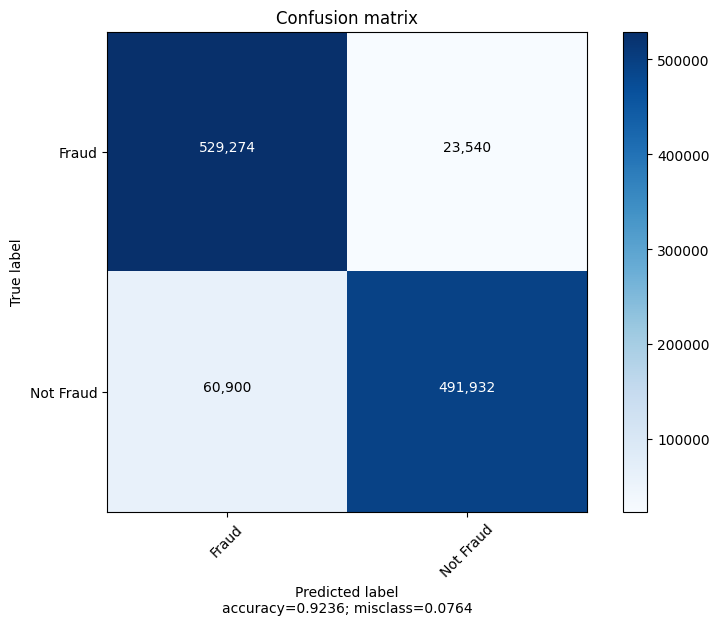

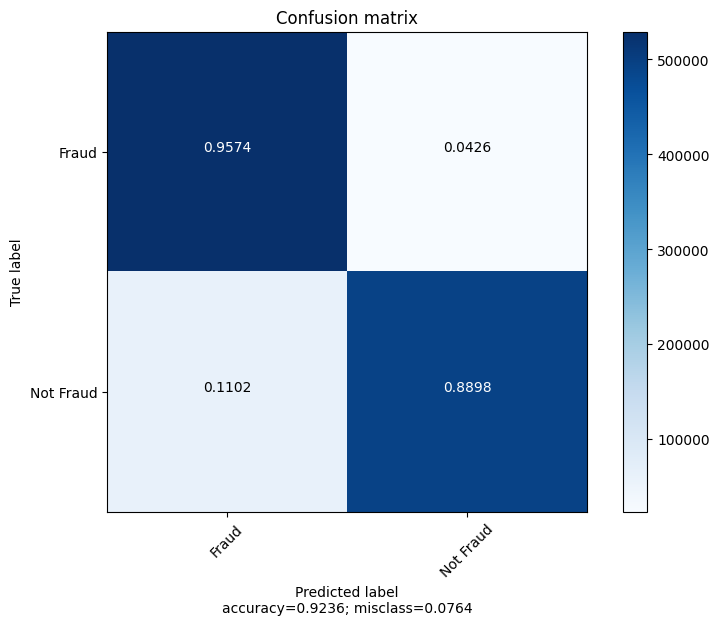

In [30]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=True)

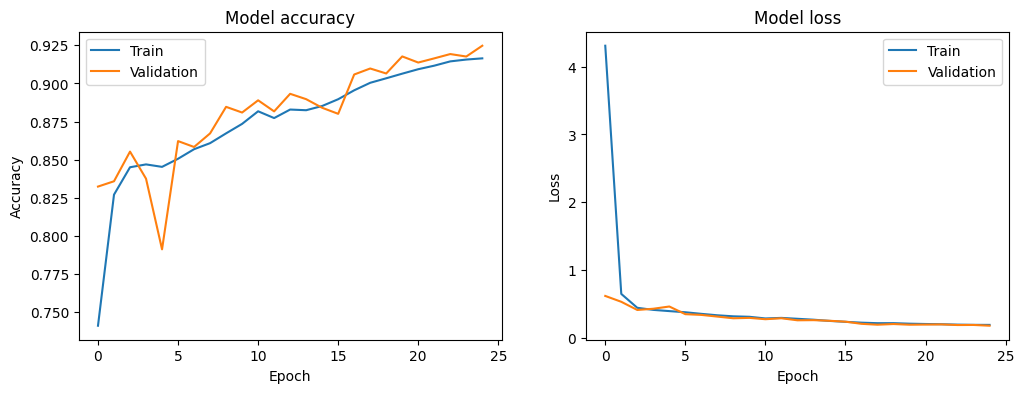

In [31]:
# Assuming history is the object returned by model.fit()
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')

    plt.show()

plot_history(history)

In [33]:
from xgboost import XGBRegressor
xgb = XGBRegressor(n_estimators=100)
xgb.fit(X_train, Y_train, early_stopping_rounds=5,eval_set=[(X_test, Y_test)], verbose=False)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
Y_pred = xgb.predict(X_test)
Y_pred = [0 if i <=0.5 else 1 for i in Y_pred]
precision_score_ab =  precision_score(Y_test, Y_pred)
accuracy_score_ab = accuracy_score(Y_test, Y_pred)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,Y_pred))

The precision score is :  97.68 %
The accuracy score is :  98.78 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    552814
           1       0.98      1.00      0.99    552832

    accuracy                           0.99   1105646
   macro avg       0.99      0.99      0.99   1105646
weighted avg       0.99      0.99      0.99   1105646



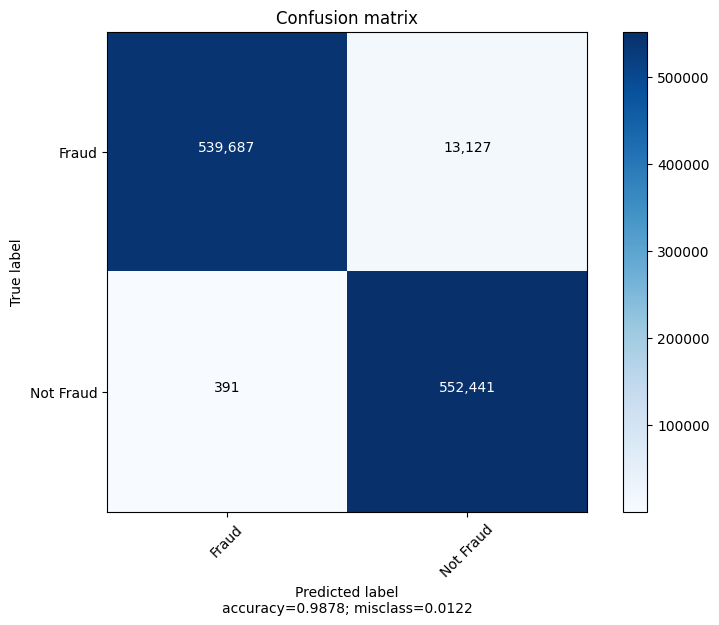

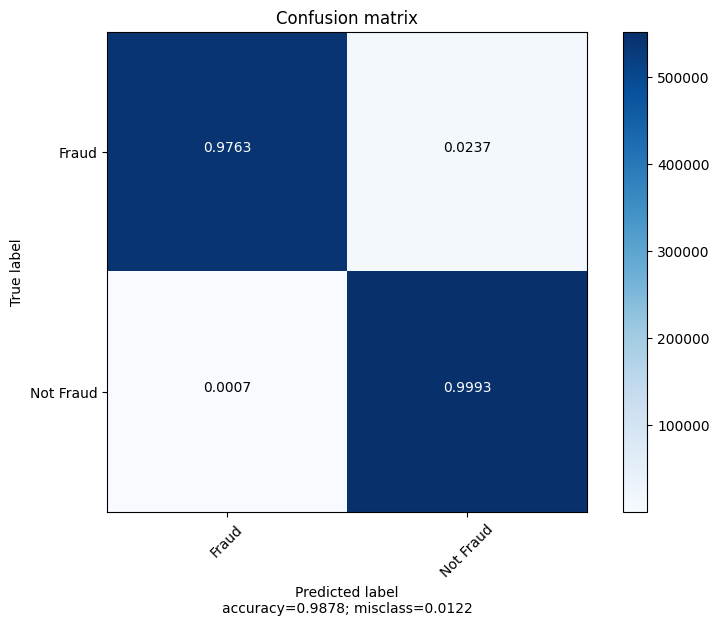

In [35]:
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,Y_pred),["Fraud","Not Fraud"],normalize=True)

In [36]:
from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier( learning_rate = 0.11042628136263043, max_depth = None, max_leaf_nodes=30,min_samples_leaf=22)
gb.fit(X_train , Y_train)

GradientBoostingClassifier(learning_rate=0.11042628136263043, max_depth=None,
                           max_leaf_nodes=30, min_samples_leaf=22)

In [37]:
y_pred = gb.predict(X_test)
precision_score_ab =  precision_score(Y_test, y_pred)
accuracy_score_ab = accuracy_score(Y_test, y_pred)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_pred))

The precision score is :  97.45 %
The accuracy score is :  98.28 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    552814
           1       0.97      0.99      0.98    552832

    accuracy                           0.98   1105646
   macro avg       0.98      0.98      0.98   1105646
weighted avg       0.98      0.98      0.98   1105646



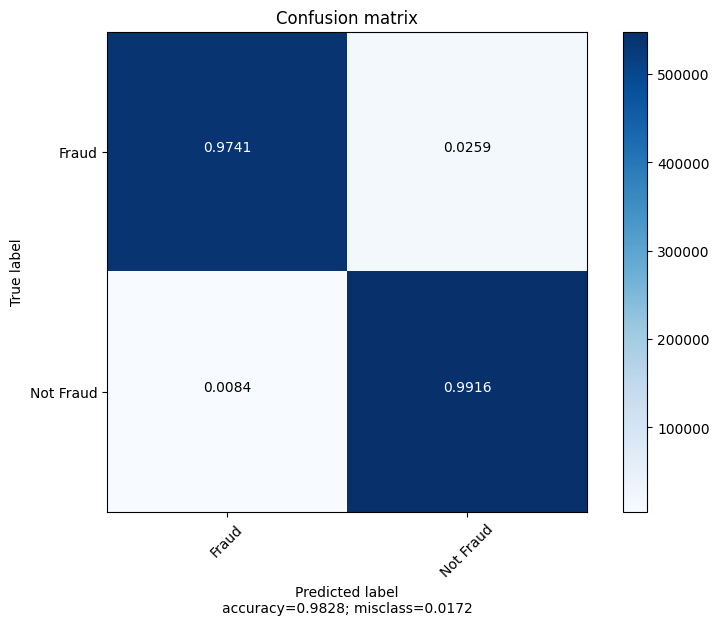

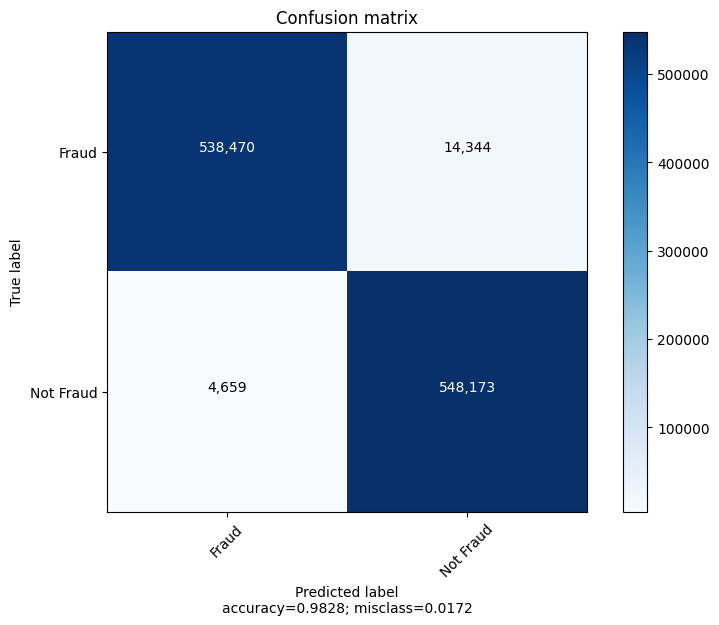

In [38]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=True)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred),["Fraud","Not Fraud"],normalize=False)

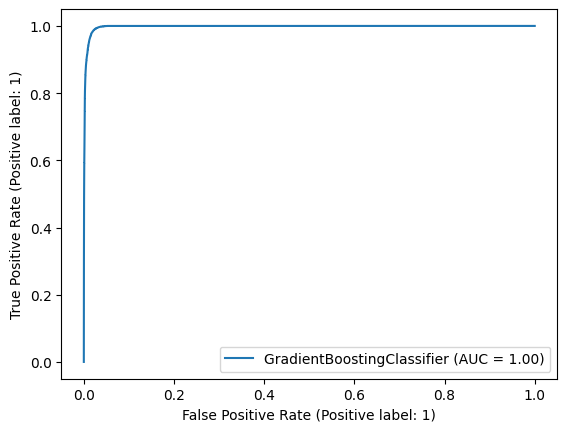

In [39]:
RocCurveDisplay.from_estimator(gb, X_test, Y_test)
plt.show()

In [40]:
# Create adaboost classifer object
dtc = DecisionTreeClassifier()
abc = AdaBoostClassifier(n_estimators=100, base_estimator=dtc,learning_rate=1.0, random_state=0)

# Train Adaboost Classifer
abc.fit(X_train, Y_train)

#Predict the response for test dataset
y_pred_lg = abc.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [41]:
precision_score_ab =  precision_score(Y_test, y_pred_lg)
accuracy_score_ab = accuracy_score(Y_test, y_pred_lg)
print('The precision score is : ',round(precision_score_ab * 100,2), '%')
print('The accuracy score is : ',round(accuracy_score_ab * 100,2), '%')
print ('\nClassification Report TEST:\n', classification_report(Y_test,y_pred_lg))

The precision score is :  99.81 %
The accuracy score is :  99.9 %

Classification Report TEST:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    552814
           1       1.00      1.00      1.00    552832

    accuracy                           1.00   1105646
   macro avg       1.00      1.00      1.00   1105646
weighted avg       1.00      1.00      1.00   1105646



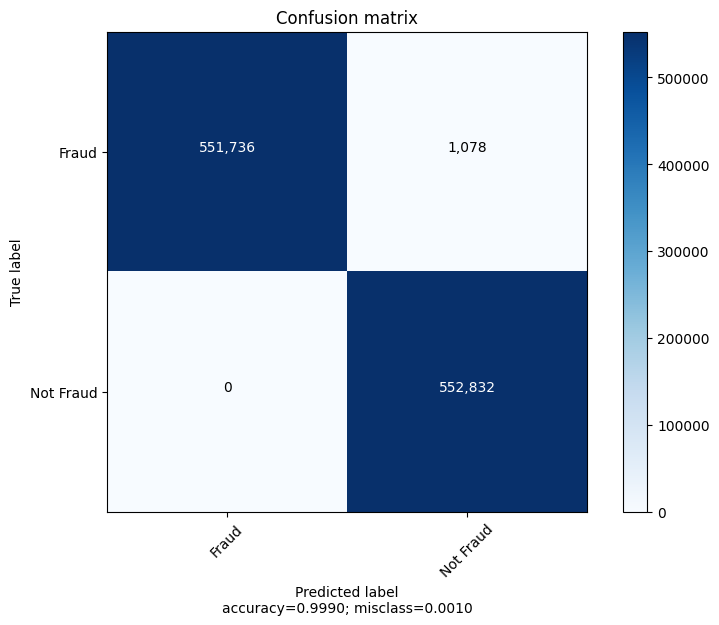

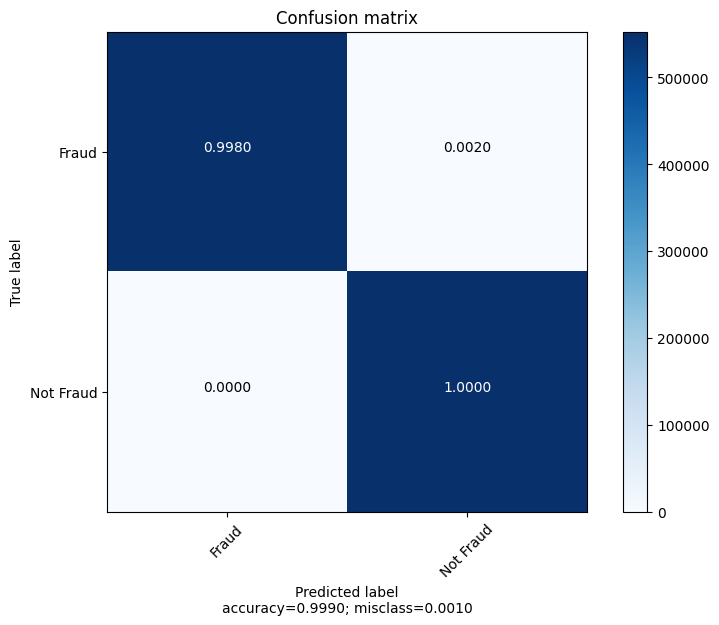

In [42]:
plot_confusion_matrix(confusion_matrix(Y_test,y_pred_lg),["Fraud","Not Fraud"],normalize=False)
plot_confusion_matrix(confusion_matrix(Y_test,y_pred_lg),["Fraud","Not Fraud"],normalize=True)

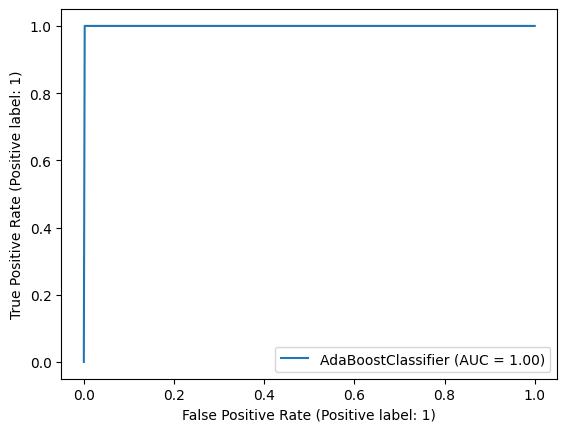

In [43]:
RocCurveDisplay.from_estimator(abc, X_test, Y_test)
plt.show()

In [44]:
matrix = classification_report(Y_test,y_pred_lg,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       1.00      1.00      1.00    552832
           0       1.00      1.00      1.00    552814

    accuracy                           1.00   1105646
   macro avg       1.00      1.00      1.00   1105646
weighted avg       1.00      1.00      1.00   1105646

